In [1]:
import sys
sys.path.append("..")


Loaded class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

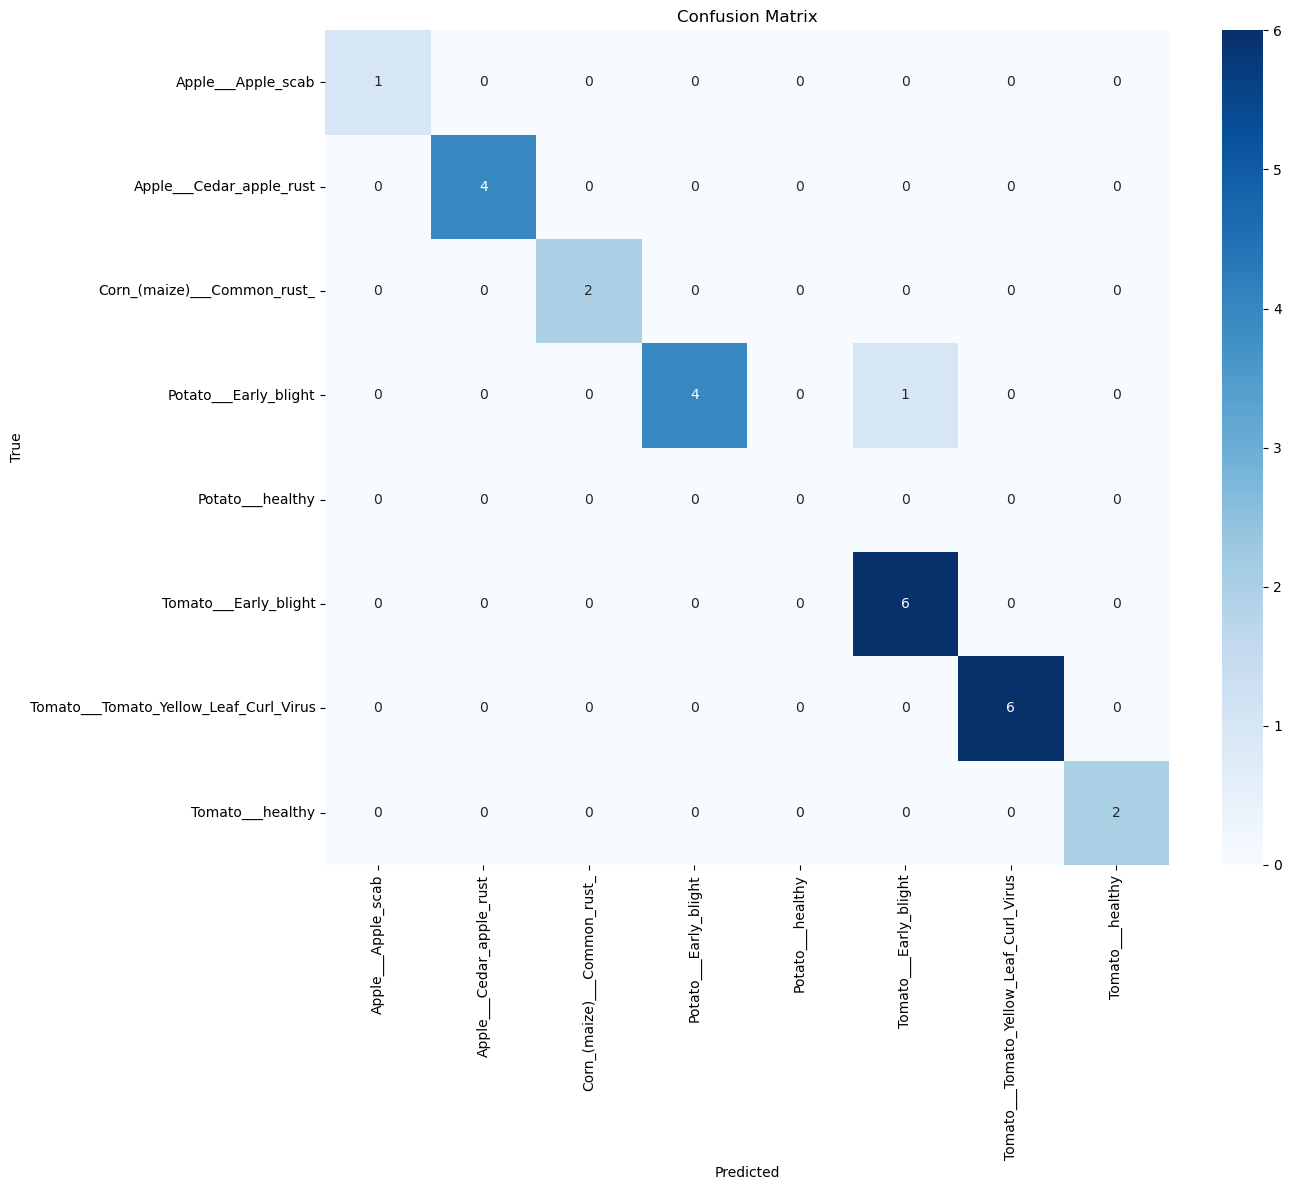

Saving per-class plots...


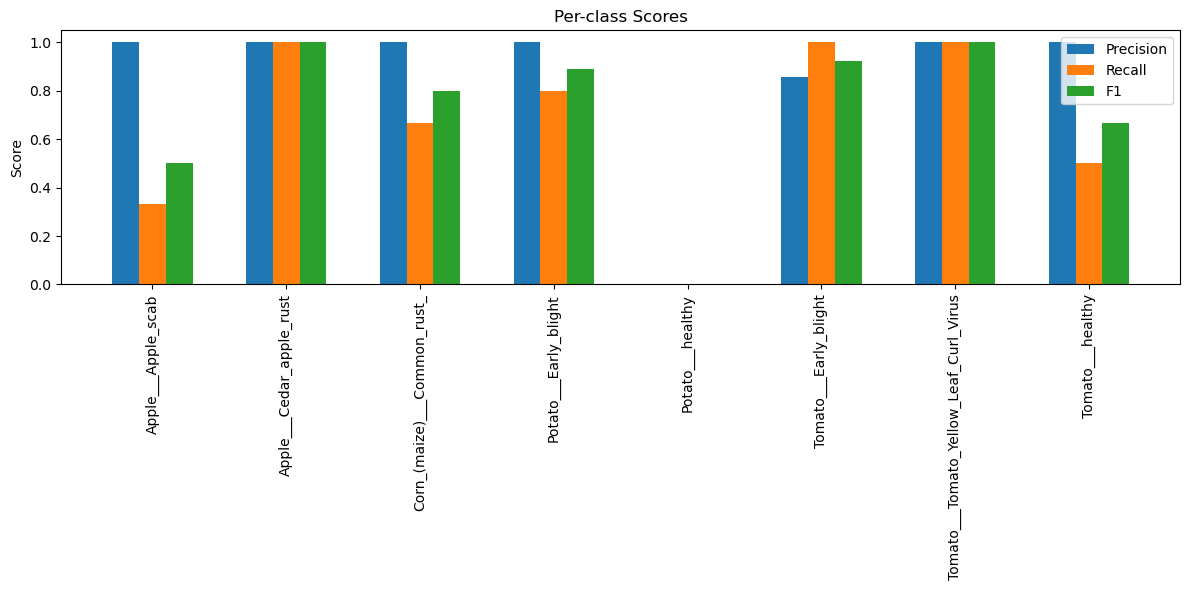

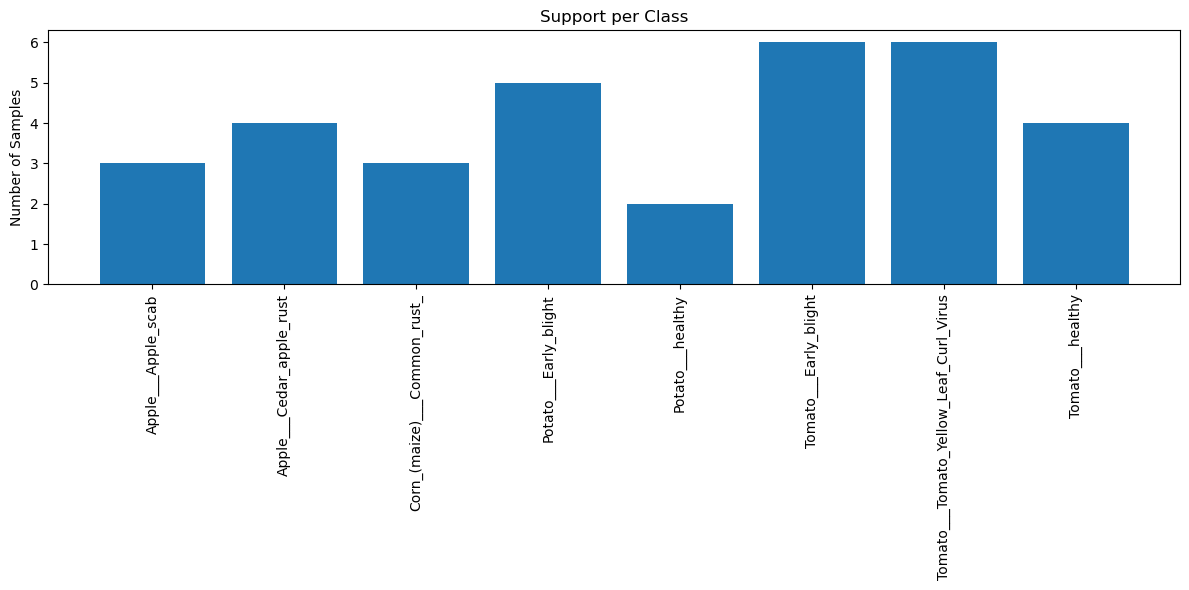

Saving ROC curves...


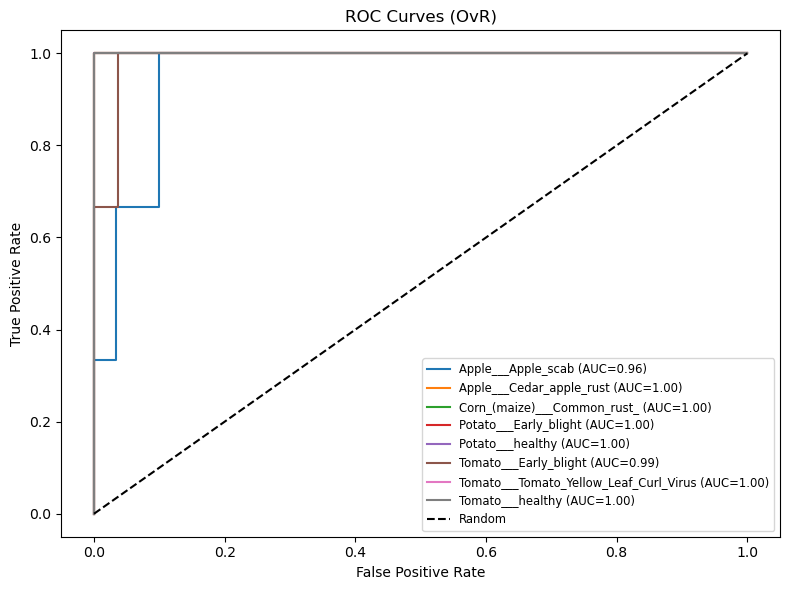

Saving PR curves...


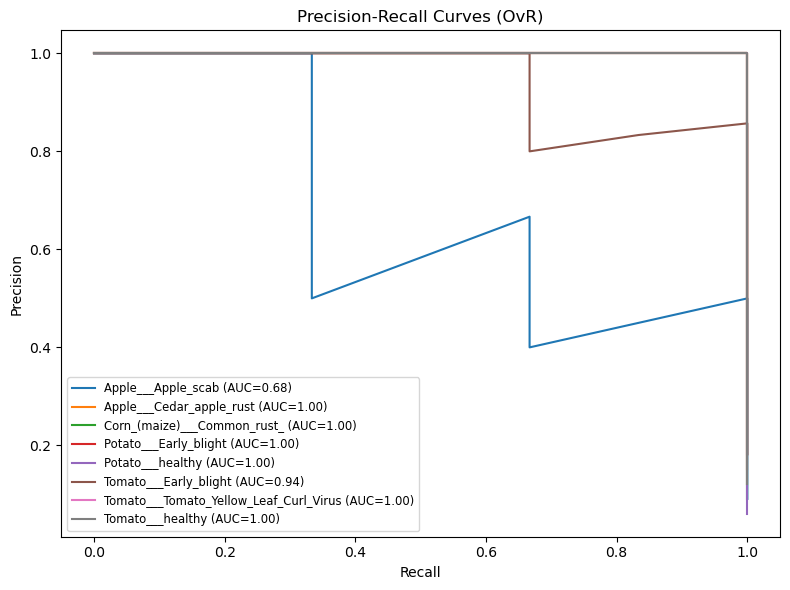


Saved all plots and metrics in: /home/ajeet/STRM-SEMESTER-PROJECT/RESNET_Methodology/ResNet_Project/collaborative_cnn_team03/results/v2_user2



In [4]:
import os
import re
import json
from pathlib import Path

import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

from models.model_v2 import PlantDiseaseResNet18


# ====================== PATHS ======================
TEST_DIR = "/home/ajeet/STRM-SEMESTER-PROJECT/RESNET_Methodology/ResNet_Project/dataset/test_restructured"
CHECKPOINT_PATH = "/home/ajeet/STRM-SEMESTER-PROJECT/RESNET_Methodology/ResNet_Project/collaborative_cnn_team03/models/model_v2.pth"

TRAIN_DIR = "/home/ajeet/STRM-SEMESTER-PROJECT/RESNET_Methodology/ResNet_Project/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

SAVE_DIR = "/home/ajeet/STRM-SEMESTER-PROJECT/RESNET_Methodology/ResNet_Project/collaborative_cnn_team03/results/v2_user2"
os.makedirs(SAVE_DIR, exist_ok=True)


# ====================== CLASS NAMES FROM TRAIN ======================
class_names = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

num_classes = len(class_names)
print("Loaded class names:", class_names)
print("Total classes:", num_classes)


def tokenize(s: str):
    s = re.sub(r'[^A-Za-z]', ' ', s)
    s = re.sub(r'([a-z])([A-Z])', r'\1 \2', s)
    tokens = s.lower().split()
    return tokens


class_tokens = {c: tokenize(c) for c in class_names}


def best_match(test_name: str) -> str:
    test_tokens = tokenize(test_name)
    best_class = None
    best_score = -1.0

    for c, toks in class_tokens.items():
        overlap = len(set(test_tokens) & set(toks))
        fuzzy = SequenceMatcher(None, test_name.lower(), c.lower()).ratio()
        score = overlap * 2.0 + fuzzy

        if score > best_score:
            best_score = score
            best_class = c

    return best_class


def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("\nUsing device:", device, "\n")

    model = PlantDiseaseResNet18(num_classes=num_classes)
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

    if "state_dict" in checkpoint:
        checkpoint = checkpoint["state_dict"]

    model_state = model.state_dict()
    loaded = {}

    print("========== MODEL WEIGHT LOADING REPORT ==========")
    for k, v in checkpoint.items():
        new_k = k.replace("module.", "").replace("model.", "")

        if new_k in model_state:
            if model_state[new_k].shape == v.shape:
                print(f"Loaded ✔ {new_k} {tuple(v.shape)}")
                loaded[new_k] = v
            else:
                print(
                    f"SKIPPED {new_k}: checkpoint {tuple(v.shape)} != model {tuple(model_state[new_k].shape)}"
                )
        else:
            print(f"Ignored {new_k} (not in model)")
    print("=================================================\n")

    model_state.update(loaded)
    model.load_state_dict(model_state)
    model.to(device)
    model.eval()
    return model, device


model, device = load_model()


tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])


def save_confusion_matrix(y_true, y_pred, shown_class_names):
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=shown_class_names,
        yticklabels=shown_class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix.png"), dpi=300)
    plt.show()
    plt.close()

    np.save(os.path.join(SAVE_DIR, "confusion_matrix.npy"), cm)
    return cm


def save_per_class_bars(report_dict, shown_class_names):
    precision = []
    recall = []
    f1 = []
    support = []

    for cname in shown_class_names:
        # report_dict keys are the string class names we passed as target_names
        stats = report_dict.get(cname, None)
        if stats is None:
            precision.append(0.0)
            recall.append(0.0)
            f1.append(0.0)
            support.append(0)
        else:
            precision.append(stats["precision"])
            recall.append(stats["recall"])
            f1.append(stats["f1-score"])
            support.append(stats["support"])

    x = np.arange(len(shown_class_names))

    # Precision / Recall / F1
    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, precision, width=0.2, label="Precision")
    plt.bar(x, recall, width=0.2, label="Recall")
    plt.bar(x + 0.2, f1, width=0.2, label="F1")
    plt.xticks(x, shown_class_names, rotation=90)
    plt.ylabel("Score")
    plt.title("Per-class Scores")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "per_class_scores.png"), dpi=300)
    plt.show()
    plt.close()

    # Support plot
    plt.figure(figsize=(12, 6))
    plt.bar(x, support)
    plt.xticks(x, shown_class_names, rotation=90)
    plt.ylabel("Number of Samples")
    plt.title("Support per Class")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "per_class_support.png"), dpi=300)
    plt.show()
    plt.close()


def save_roc_curves(y_true, y_prob, shown_label_indices, shown_class_names):
    n_classes_full = y_prob.shape[1]

    # Binarize across all classes (0..num_classes-1)
    y_bin = label_binarize(y_true, classes=list(range(n_classes_full)))

    plt.figure(figsize=(8, 6))
    any_plotted = False
    for idx, cname in zip(shown_label_indices, shown_class_names):
        if y_bin[:, idx].sum() == 0 or y_bin[:, idx].sum() == len(y_bin):
            continue
        fpr, tpr, _ = roc_curve(y_bin[:, idx], y_prob[:, idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.2f})")
        any_plotted = True

    if not any_plotted:
        print("No valid classes for ROC curves; skipping.")
        plt.close()
        return

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (OvR)")
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "roc_curves.png"), dpi=300)
    plt.show()
    plt.close()


def save_pr_curves(y_true, y_prob, shown_label_indices, shown_class_names):
    n_classes_full = y_prob.shape[1]
    y_bin = label_binarize(y_true, classes=list(range(n_classes_full)))

    plt.figure(figsize=(8, 6))
    any_plotted = False
    for idx, cname in zip(shown_label_indices, shown_class_names):
        if y_bin[:, idx].sum() == 0 or y_bin[:, idx].sum() == len(y_bin):
            continue
        precision, recall, _ = precision_recall_curve(y_bin[:, idx], y_prob[:, idx])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{cname} (AUC={pr_auc:.2f})")
        any_plotted = True

    if not any_plotted:
        print("No valid classes for PR curves; skipping.")
        plt.close()
        return

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (OvR)")
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "pr_curves.png"), dpi=300)
    plt.show()
    plt.close()


# ====================== INFERENCE ======================
y_true, y_pred = [], []
y_prob_list = []

print("Folder → matched train class:")
for folder in sorted(os.listdir(TEST_DIR)):
    folder_path = os.path.join(TEST_DIR, folder)
    if not os.path.isdir(folder_path):
        continue

    matched_class = best_match(folder)
    print(f"  {folder}  ->  {matched_class}")

print("\nRunning inference...\n")

for folder in os.listdir(TEST_DIR):
    folder_path = os.path.join(TEST_DIR, folder)
    if not os.path.isdir(folder_path):
        continue

    true_class = best_match(folder)
    if true_class is None:
        print(f"Could not match folder {folder} to any class → skipping")
        continue

    true_idx = class_names.index(true_class)

    for fname in os.listdir(folder_path):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(folder_path, fname)
        img = Image.open(img_path).convert("RGB")
        x = tfms(img).unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(x)
            probs = torch.softmax(out, dim=1).cpu().numpy()[0]
            pred_idx = int(np.argmax(probs))

        y_true.append(true_idx)
        y_pred.append(pred_idx)
        y_prob_list.append(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.vstack(y_prob_list)

# ====================== METRICS ======================
print("\n========== RESULTS ==========")
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# only use labels that actually appear in y_true
unique_labels = sorted(list(set(y_true)))
shown_class_names = [class_names[i] for i in unique_labels]

print("\nClassification Report:")
report_dict = classification_report(
    y_true,
    y_pred,
    labels=unique_labels,
    target_names=shown_class_names,
    output_dict=True,
    zero_division=0
)
report_str = classification_report(
    y_true,
    y_pred,
    labels=unique_labels,
    target_names=shown_class_names,
    zero_division=0
)
print(report_str)

# Save text report
with open(os.path.join(SAVE_DIR, "classification_report.txt"), "w") as f:
    f.write(f"Accuracy: {acc:.4f}\n\n")
    f.write(report_str)

# Save metrics as JSON
metrics = {
    "accuracy": acc,
    "classification_report": report_dict
}
with open(os.path.join(SAVE_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=4)

# ====================== PLOTS ======================
print("Saving confusion matrix...")
cm = save_confusion_matrix(y_true, y_pred, shown_class_names)

print("Saving per-class plots...")
save_per_class_bars(report_dict, shown_class_names)

print("Saving ROC curves...")
save_roc_curves(y_true, y_prob, unique_labels, shown_class_names)

print("Saving PR curves...")
save_pr_curves(y_true, y_prob, unique_labels, shown_class_names)

print("\nSaved all plots and metrics in:", Path(SAVE_DIR).absolute())
print("=================================\n")
